<a href="https://colab.research.google.com/github/MLcmore2023/MLcmore2023/blob/main/day6_am_morning/kmeans-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-means
K-means is an unsupervised machine learning algorithm used for clustering. It aims to partition a given dataset into k distinct clusters based on similarity. The algorithm starts by randomly selecting k data points as initial cluster centroids and then iteratively assigns each data point to the nearest centroid, forming clusters. The centroids are updated by computing the mean of all data points assigned to each cluster. This process continues until convergence, where the centroids no longer change significantly.






### Import libraries and initialize random generator

In [54]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px # for plotting
np.random.seed(5)


### Read data from CSV
we will use the wholesale customers dataset. The data set includes the annual spending amount on 8 product categories of 440 customers. We will try to group these customers into different clusters, which in real life may represent groups such as individual buyers, business owners, tourists ... (these are just examples. K means does not give any labels)

https://archive.ics.uci.edu/dataset/292/wholesale+customers

In [55]:
dataset = pd.read_csv("https://raw.githubusercontent.com/TrainingByPackt/Data-Science-with-Python/master/Chapter01/Data/Wholesale%20customers%20data.csv")
display(dataset)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


### Standardizing dataset values
K-means clustering is sensitive to the scales of the features, and features with larger scales can dominate the clustering algorithm. By standardizing the dataset, we transform the features to have a mean of 0 and a standard deviation of 1, which brings all features to a similar scale (i.e. using z-scores instead of raw values). This allows K-means to treat all features equally and prevent any single feature from dominating the clustering process based on its scale.

In [56]:
def standardize_data(dataset):
    mean = np.mean(dataset, axis=0)  # Calculate the mean along the columns
    std = np.std(dataset, axis=0)    # Calculate the standard deviation along the columns
    data_scaled = (dataset - mean) / std  # Standardize the dataset
    return data_scaled

dataset = standardize_data(dataset)

display(dataset)
dataset = dataset.to_numpy() # convert to numpy array for processing later

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.448652,0.590668,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339
1,1.448652,0.590668,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151
2,1.448652,0.590668,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293
3,-0.690297,0.590668,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411
4,1.448652,0.590668,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347
...,...,...,...,...,...,...,...,...
435,-0.690297,0.590668,1.401312,0.848446,0.850760,2.075222,-0.566831,0.241091
436,-0.690297,0.590668,2.155293,-0.592142,-0.757165,0.296561,-0.585519,0.291501
437,1.448652,0.590668,0.200326,1.314671,2.348386,-0.543380,2.511218,0.121456
438,-0.690297,0.590668,-0.135384,-0.517536,-0.602514,-0.419441,-0.569770,0.213046


## K-means algorithm
- Step 1: Choose the number of clusters k
- Step 2: Select k random points from the data as centroids
- Step 3: Assign all the points to the closest cluster centroid
- Step 4: Recompute the centroids of newly formed clusters
- Step 5: Repeat steps 3 and 4



In [57]:
#Step 2: Select k random points from the data as centroids
def initialize_random_centroids(X, K):
    num_examples, num_features = X.shape
    centroids = np.zeros((K, num_features))
    for k in range(K):
        centroid = X[np.random.choice(range(num_examples))]
        centroids[k] = centroid
    return centroids

#Assigns each data point in X to its closest centroid, forming clusters.
def create_cluster(X, centroids, K):
    num_examples = X.shape[0]

    #make empty 2d list
    clusters = []
    for counter in range(K):
        clusters.append([])

    for point_idx, point in enumerate(X):
        distances = np.sqrt(np.sum((point - centroids) ** 2, axis=1))
        closest_centroid = np.argmin(distances)
        clusters[closest_centroid].append(point_idx)
    return clusters

#Calculates new centroids by taking the mean of the data points in each cluster.
def calculate_new_centroids(clusters, X, K):
    num_features = X.shape[1]
    centroids = np.zeros((K, num_features))
    for idx, cluster in enumerate(clusters):
        new_centroid = np.mean(X[cluster], axis=0)
        centroids[idx] = new_centroid
    return centroids

#Assigns cluster labels to each data point based on the cluster it belongs to.
def predict_cluster(clusters, X):
    num_examples = X.shape[0]
    y_pred = np.zeros(num_examples)
    for cluster_idx, cluster in enumerate(clusters):
        for sample_idx in cluster:
            y_pred[sample_idx] = cluster_idx
    return y_pred

#Performs the K-means clustering algorithm on the data X. It initializes centroids, creates clusters, updates centroids iteratively, and predicts cluster labels.
def fit(X, num_clusters, max_iterations=100):
    centroids = initialize_random_centroids(X, num_clusters)
    for i in range(max_iterations):
        clusters = create_cluster(X, centroids, num_clusters)
        previous_centroids = centroids
        centroids = calculate_new_centroids(clusters, X, num_clusters)

        diff = centroids - previous_centroids
        if not diff.any():
            break
    y_pred = predict_cluster(clusters, X)
    wcss = calculate_wcss(clusters, centroids, X)
    return y_pred, wcss


def calculate_wcss(clusters, centroids, X):
    wcss = 0  # Initialize WCSS
    for cluster_idx, cluster in enumerate(clusters):
        centroid = centroids[cluster_idx]
        cluster_points = X[cluster]
        distances = np.sum((cluster_points - centroid) ** 2, axis=1)
        wcss += np.sum(distances)
    return wcss


## Test on generated data
We run the kmeans algorithm on a simple generated dataset to show the results.  This generated data have 2 features and 3 centers.

In [58]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=3)
px.scatter(X[:,0],X[:, 1]).show()

Here, we will use our function to cluster the data. We will arbitrarily choose
K=3, and graph out the 3 clusters in red, blue and yellow.

In [59]:
y_pred, wcss = fit(X, num_clusters=3)
px.scatter(X[:, 0], X[:, 1], color=y_pred).show()
print("WCSS:", wcss)

WCSS: 172.37292544790057


## Elbow Method
The optimal value for the number of clusters, K, can be determined using the Elbow method. The Elbow method aims to minimize the sum of squares of distances between data points and their cluster centroids, known as Within-Cluster Sums of Squares (WCSS). Choosing too few clusters results in high WCSS, while selecting too many clusters may lead to WCSS of 0. Therefore, the Elbow method helps find the appropriate K by identifying the point on the plot where adding more clusters does not significantly reduce WCSS.
- Step 1. Perform K means clustering on different values of K ranging from 1 to any upper limit. Here we are taking the upper limit as 7.
- Step 2. For each K, calculate WCSS
- Step 3. Plot the value for WCSS with the number of clusters K.
- Step 4. The location of a bend (knee) in the plot is generally considered as an indicator of the appropriate number of clusters. i.e the point after which WCSS doesn’t decrease more rapidly is the appropriate value of K.



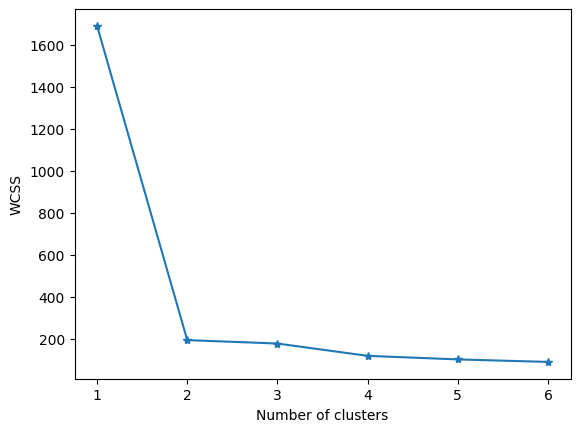

In [60]:
SSE = []
for num_clusters in range(1,7):
    y_pred, wcss = fit(X, num_clusters)
    SSE.append(wcss)
import matplotlib.pyplot as plt
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.plot([1,2,3,4,5,6], SSE, marker="*")

we can see that WCSS stopped having significant decreases after 2. Therefore, k=2 is the optimal amount of clusters.

In [67]:
num_clusters = 2
y_pred, wcss = fit(X, num_clusters)
px.scatter(X[:, 0], X[:, 1], color=y_pred).show()
print("WCSS:", wcss)


## Exercise

__Question 0:__
Run the K-means algorithm on the wholesale customer dataset (`dataset`).

__Question 1:__
based on the results, can you tell what types of customers are there in our dataset?

__Question 2:__
Explain how is K=2 chosen.

__Question 3:__

we have one more problem left which is random initialization. This is a problem because if two initial centroids are very near, it would take a lot of iterations for the algorithm to converge and so something need to be done in order to make sure that initial centroids are far apart from each other. This is Described as KMeans++ algorithm, where only the initialization of the centroids will change. Everything else is similar to before.

The goal of the KMeans++ initialization is that chosen centroids should be far from one another. The first cluster center is chosen uniformly at random from the data points that are being clustered, after which each subsequent cluster center is chosen from the remaining data points with probability proportional to its squared distance from the point's closest existing cluster center. This will be understood well if we represent it as steps.
1. Randomly select the first cluster center from the data points and append it to the centroid matrix.
2. Loop over the number of Centroids that need to be chosen (K):
3. For each data point calculate the euclidian distance square from already chosen centroids and append the minimum distance to a Distance array.
4. Calculate the probabilities of choosing the particular data point as the next centroid by dividing the Distance array elements with the sum of Distance array. Let’s call this probability distribution as PD.
5. Calculate the cumulative probability distribution from this PD distribution. We knew that the cumulative probability distribution ranges from 0 to 1.
6. Select a random number between 0 to 1, get the index (i) of the cumulative probability distribution which is just greater than the chosen random number and assign the data point corresponding to the selected index (i).
7. Repeat the process until we have K number of cluster centers.



In [62]:
#exercise: code here
import random

def initialize_random_centroids(X, K):
    # Randomly select the first cluster center from the data points and append it to the centroid matrix.
    i = # code here
    centroids= # code here
    for j in range(1,K):
        distances=np.array([])
        # For each data point calculate the euclidian distance square from already chosen centroids and append the minimum distance to a Distance array.
        for x in X:
            distances = np.append(distances, np.min(np.sum((x-centroids)**2)))
        # Calculate the probabilities of choosing the particular data point as the next centroid by dividing the Distance array elements with the sum of Distance array
        probability = # code here

        # Calculate the cumulative probability distribution from this distribution. We knew that the cumulative probability distribution ranges from 0 to 1.
        cummulative_prob= # code here

        # Select a random number between 0 to 1, get the index (i) of the cumulative probability distribution which is just greater than the chosen random number and assign the data point corresponding to the selected index (i).
        r = random.random()
        i=0
        for j,p in enumerate(cummulative_prob):
            if r<p:
                i=j
                break
        centroids=np.append(centroids,[X[i]],axis=0)
    return centroids

### References
- https://www.kaggle.com/code/adinishad/kmeans-clustering-from-scratch
- https://medium.com/machine-learning-algorithms-from-scratch/k-means-clustering-from-scratch-in-python-1675d38eee42
- https://towardsdatascience.com/create-your-own-k-means-clustering-algorithm-in-python-d7d4c9077670